In [17]:
# Imports
import glob
import numpy as np
from nilearn import image, plotting
from nilearn.image import new_img_like
import os
import scipy.io

In [124]:
main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast' #main folder with data
bck_img_map = image.load_img(os.path.join(main_folder, 'MNI152_T1_1mm_Brain.nii')) #Background for plotting purposes
#List of subjects
subjects = ['01','02','03','04','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','22','23','24']
#subjects = ['01','02']

dcm_data_day1_path = os.path.join(main_folder,'Day1_all_EPvalues.mat') #mat file with DCM results of day 1
dcm_data_day1 = scipy.io.loadmat(dcm_data_day1_path)
#NB this file contains results for all 22 subjects for all 3 polarities (anodal, cathodal and sham)
#And the order is anodal, cathodal and sham for each subject (so I'm only interested in matrices 0, 3, 6 ... etc)

In [125]:
#Loading ROIs
m1_path = os.path.join(main_folder,'rois','m1.nii')
th_path = os.path.join(main_folder,'rois','th.nii')
m1 = image.load_img(m1_path)
th = image.load_img(th_path)

In [127]:
pos_dcm_res = 0 #Position of the DCM results for subject 1, day 1 (anodal)

# Where I'll save m1 self connections and all th->m1
all_m1selfcon = []
all_thm1 = []

# Where I'll save emag values for m1 and th for each subject
all_m1_emag = []
all_th_emag = []

for sbj in subjects:
    print('Analysing subject: ' + sbj)
    path = 'D:\\roast-chapter3\wp2a\sub-' + sbj
    print('Path: ' + path)
    
    #Loading ROAST field magnitude simulation
    emag_map = image.load_img(glob.glob(path+ '/swsub-*_T1_*_emag.nii')) 
    emag_data = emag_map.get_fdata() 
    
    #Loading binary map for the subject (c1 = grey matter, c2 = white matter)
    anat_map = image.load_img(glob.glob(path+ '/c1c2bin.nii')) #Loading c1/c2 masks
    anat_data = anat_map.get_fdata()
    
    #Emag map masked using c1c2 masks (to keep only values in white/grey matter)
    emag_msk = np.where(anat_data > 0, emag_data, 0) 
    emag_msk = emag_msk.reshape([157,189,156])
    emag_map_msk = new_img_like(emag_map,emag_msk) # new emag image containing only values within the brain
    
    # Resampling ROIs to the dimention of the emag map
    m1_resampled = image.resample_to_img(m1,emag_map_msk, interpolation = 'nearest')
    th_resampled = image.resample_to_img(th,emag_map_msk, interpolation = 'nearest')
    
    #Loading DCM results for the subject
    this_dcm = np.array(dcm_data_day1['ALLEP'][0][pos_dcm_res].todense().reshape((4,4)))   
    #print(this_dcm)
    
    # I am only interested in m1 self connectivity and th->m1
    m1m1 = this_dcm[0][0]
    thm1 = this_dcm[0][1]
    
    # Saving the values
    all_m1selfcon.append(m1m1)
    all_thm1.append(thm1)
    
    print('M1<->M1 connectivity: ' + str(m1m1))
    print('Th<->M1 connectivity: ' + str(thm1))

    # Calculating the mean of the electric field intensity for M1 and TH
    # For this I first need to mask the emag map
    emag_masked_m1 = image.math_img("img * img2", img=emag_map_msk, img2 = m1_resampled) #Applying m1 mask
    emag_masked_th = image.math_img("img * img2", img=emag_map_msk, img2 = th_resampled) #Applying th mask
    
    # Assigning nans to zeroes to exclude non M1 voxels from the calculation of the mean
    emag_masked_m1_nans = np.where(m1_resampled.get_fdata() == 0, np.nan, emag_masked_m1.get_fdata())
    emag_masked_th_nans = np.where(th_resampled.get_fdata() == 0, np.nan, emag_masked_th.get_fdata())

    # Calculating means
    m1_emag_mean = np.nanmean(emag_masked_m1_nans)
    th_emag_mean = np.nanmean(emag_masked_th_nans)
    
    # Saving the values
    all_m1_emag.append(m1_emag_mean)
    all_th_emag.append(th_emag_mean)   
    
    print('Mean Electric field value in M1: ' + str(m1_emag_mean))
    print('Mean Electric field value in Th: ' + str(th_emag_mean))
    print('\n')
    pos_dcm_res += 3 #Moving to the next subject
    

Analysing subject: 01
Path: D:\roast-chapter3\wp2a\sub-01
M1<->M1 connectivity: 0.05520965013149901
Th<->M1 connectivity: -0.07975793559423307
Mean Electric field value in M1: 0.1674830709569266
Mean Electric field value in Th: 0.07424893171272495


Analysing subject: 02
Path: D:\roast-chapter3\wp2a\sub-02
M1<->M1 connectivity: -0.3622170140993727
Th<->M1 connectivity: 0.009976267482675176
Mean Electric field value in M1: 0.15881597148640145
Mean Electric field value in Th: 0.07654037188717418


Analysing subject: 03
Path: D:\roast-chapter3\wp2a\sub-03
M1<->M1 connectivity: -0.47099440513360225
Th<->M1 connectivity: -0.050989560217344625
Mean Electric field value in M1: 0.15538377634588244
Mean Electric field value in Th: 0.07749358916358853


Analysing subject: 04
Path: D:\roast-chapter3\wp2a\sub-04
M1<->M1 connectivity: 0.38944055779915
Th<->M1 connectivity: -0.04625637970749385
Mean Electric field value in M1: 0.1677312717394786
Mean Electric field value in Th: 0.08604534333233128



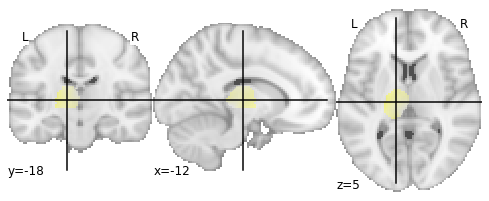

In [109]:
plotting.plot_roi(emag_map_msk,
                  cmap = 'hot_r',
                  threshold = 0, vmax = 0.36, alpha = 0.45,
                  black_bg = False)

#image.math_img("img", img=mesh_map).to_filename('meshed.nii')


Correlation m1 self connectivity and m1 electric field intensity
p value: 0.167713, r=0.304867


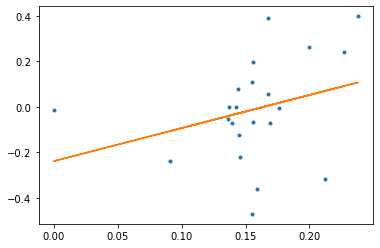

In [134]:
# Correlation m1 self connectivity and m1 electric field intensity

x = np.transpose(all_m1_emag)
y = np.transpose(all_m1selfcon)

r,p  = scipy.stats.pearsonr(x, y)    # Pearson's r
print('Correlation m1 self connectivity and m1 electric field intensity')
print('p value: ' + str(round(p,6)) + ', r=' + str(round(r,6)))
# Plot
from numpy.polynomial.polynomial import polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

Correlation m1 self connectivity and m1 electric field intensity
p value: 0.895722, r=0.02967


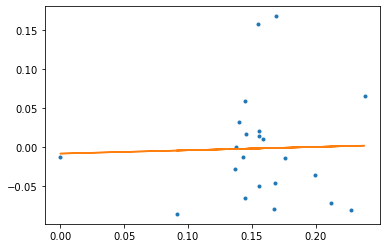

In [136]:
# Correlation th->m1 connectivity and m1 electric field intensity

x = np.transpose(all_m1_emag)
y = np.transpose(all_thm1)

r,p  = scipy.stats.pearsonr(x, y)    # Pearson's r
print('Correlation m1 self connectivity and m1 electric field intensity')
print('p value: ' + str(round(p,6)) + ', r=' + str(round(r,6)))
# Plot
from numpy.polynomial.polynomial import polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

In [138]:
all_m1_emag

[0.1674830709569266,
 0.15881597148640145,
 0.15538377634588244,
 0.1677312717394786,
 0.0,
 0.1373662132076746,
 0.23807333707909817,
 0.2120799319599388,
 0.19954907841440575,
 0.13637196905982285,
 0.1443874707418561,
 0.15552644211042438,
 0.13969757171084662,
 0.14448720581501498,
 0.14290343333929523,
 0.15494562573472098,
 0.1758734414407321,
 0.22712321753201078,
 0.16888430928024323,
 0.1452808106971574,
 0.09100511988732696,
 0.15554585621702277]